In [1]:
import sys
import os
import json
import tensorflow as tf
import tqdm
from models.model import *
from ltv_utils import *
from losses.custom_loss import *
pd.set_option('display.float_format', '{:.4f}'.format)  # 保留10位小数，可调整
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)




def parse_function(serialized_example):
    feature_description = {
        'deviceid': tf.io.FixedLenFeature([], tf.string),
        'install_date': tf.io.FixedLenFeature([], tf.string),
        'dim_os_name1': tf.io.FixedLenFeature([], tf.string),
        'creative_classify1': tf.io.FixedLenFeature([], tf.string),
        'total_pay_amount1':  tf.io.FixedLenFeature([], tf.float32),
         'channel1': tf.io.FixedLenFeature([], tf.string),
        'b2_sale_amt_bias':  tf.io.FixedLenFeature([], tf.int64),
         'b2_sale_amt_7d': tf.io.FixedLenFeature([], tf.int64),
         'install_time': tf.io.FixedLenFeature([], tf.string),
        'install_order_diff':  tf.io.FixedLenFeature([], tf.int64),
        'all_install_order_7d_diff':  tf.io.FixedLenFeature([], tf.int64),
        'is_a1x_a33':  tf.io.FixedLenFeature([], tf.int64),
        'platform_label':  tf.io.FixedLenFeature([], tf.string),
        'user_dense_price_features': tf.io.FixedLenFeature([len(group_2_features['user_dense_price_features'])], tf.float32),
        'user_dense_duration_features': tf.io.FixedLenFeature([len(group_2_features['user_dense_duration_features'])], tf.float32),
        'user_dense_features': tf.io.FixedLenFeature([len(group_2_features['user_dense_features'])], tf.float32),
        'user_sparse_features': tf.io.FixedLenFeature([len(group_2_features['user_sparse_features'])], tf.float32)
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    return example


# load tf records
group_2_features = read_feature_json_config('features/feature_list.json')
file_name = 'data/loca_test_tf.tfrecords'
data_path = file_name

dataset = tf.data.TFRecordDataset(data_path)
dataset = dataset.map(parse_function)

dataset = dataset.prefetch(buffer_size=10000)
dataset = dataset.batch(512)

user_dense_price_features = group_2_features['user_dense_price_features']
user_dense_duration_features = group_2_features['user_dense_duration_features']
user_dense_features = group_2_features['user_dense_features']
user_sparse_features = group_2_features['user_sparse_features']


In [2]:
def create_tf_dataset(dataset):
    sample_batch = next(iter(dataset))
    sample_data = {k: v for k, v in sample_batch.items() if k not in ['b2_sale_amt_7d', 'total_pay_amount1']}

    def generator():
        for batch in dataset:
            b2_7d = tf.cast(tf.reshape(batch.pop('b2_sale_amt_7d'), (-1, 1)), tf.float32)
            total_amt_1h = tf.reshape(batch.pop('total_pay_amount1'), (-1, 1))
            y_true_packed = tf.concat([b2_7d, total_amt_1h], axis=1)
            yield batch, y_true_packed

    # 正确写法：output_signature 中保留每个字段的真实 shape
    output_signature = (
        {
            name: tf.TensorSpec(shape=(None,) + v.shape[1:], dtype=v.dtype)
            for name, v in sample_data.items()
        },
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
    )

    return tf.data.Dataset.from_generator(generator, output_signature=output_signature)

In [3]:

emb_features = [
'creative_classify','dim_device_manufacture', 'car_add_type_most','show_order_is_2arrival_latest', 'selecttirecount_most', 'show_order_is_2arrival_most','selecttirecount_latest',
 'new_sitename','advsite','car_add_type_latest','platform_level', 'tire_list_click_avg_index','tire_list_click_most_pid_level','tire_order_page_most_pid_level',
]


model = MULTI_HEAD_LTV_MODEL(5, [200,200], [200,128], 'user_dense_features', 'user_dense_price_features', 'user_dense_duration_features',
                            'user_sparse_features',user_sparse_features, emb_features)


sample = next(iter(dataset))
input_shape = {k: v.shape for k, v in sample.items()}


2025-06-19 18:02:06.910420: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [4]:
input_shape

{'all_install_order_7d_diff': TensorShape([512]),
 'b2_sale_amt_7d': TensorShape([512]),
 'b2_sale_amt_bias': TensorShape([512]),
 'channel1': TensorShape([512]),
 'creative_classify1': TensorShape([512]),
 'deviceid': TensorShape([512]),
 'dim_os_name1': TensorShape([512]),
 'install_date': TensorShape([512]),
 'install_order_diff': TensorShape([512]),
 'install_time': TensorShape([512]),
 'is_a1x_a33': TensorShape([512]),
 'platform_label': TensorShape([512]),
 'total_pay_amount1': TensorShape([512]),
 'user_dense_duration_features': TensorShape([512, 6]),
 'user_dense_features': TensorShape([512, 83]),
 'user_dense_price_features': TensorShape([512, 9]),
 'user_sparse_features': TensorShape([512, 22])}

In [15]:
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_auc',  # 监控验证集上的 loss
#     patience=3,          # 如果连续 3 轮没有改善，就停止训练
#     restore_best_weights=True  # 训练结束后恢复到最优模型
# )
loss_fn = UnifiedLTVLoss('mse')
model.compile(loss=loss_fn, optimizer = 'adam')
# 提前构造 input_shape
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,       # ✅ 这一步关键
    profile_batch='5,10'    # ✅ 让 Profiler 在第5~10个 batch 才执行
)
model.fit(
    create_tf_dataset(dataset),
    epochs=10,
    callbacks=[tensorboard_callback]
)


        

Epoch 1/10


2025-06-19 19:02:53.675440: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2025-06-19 19:02:53.675457: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2025-06-19 19:02:53.675657: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.


Tensor("multi_head_ltv_model/ExpandDims:0", shape=(None, 1), dtype=float32)
Tensor("multi_head_ltv_model/ExpandDims:0", shape=(None, 1), dtype=float32)
      9/Unknown - 2s 14ms/step

2025-06-19 19:02:55.772774: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2025-06-19 19:02:55.772788: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2025-06-19 19:02:56.674875: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2025-06-19 19:02:56.742878: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2025-06-19 19:02:56.798394: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fit/20250619-190253/plugins/profile/2025_06_19_19_02_56

2025-06-19 19:02:56.862695: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/fit/20250619-190253/plugins/profile/2025_06_19_19_02_56/CK-L220022-2.local.trace.json.gz


     27/Unknown - 3s 51ms/step

2025-06-19 19:02:56.879033: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fit/20250619-190253/plugins/profile/2025_06_19_19_02_56

2025-06-19 19:02:56.879270: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/fit/20250619-190253/plugins/profile/2025_06_19_19_02_56/CK-L220022-2.local.memory_profile.json.gz
2025-06-19 19:02:56.880243: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/fit/20250619-190253/plugins/profile/2025_06_19_19_02_56
Dumped tool data for xplane.pb to logs/fit/20250619-190253/plugins/profile/2025_06_19_19_02_56/CK-L220022-2.local.xplane.pb
Dumped tool data for overview_page.pb to logs/fit/20250619-190253/plugins/profile/2025_06_19_19_02_56/CK-L220022-2.local.overview_page.pb
Dumped tool data for input_pipeline.pb to logs/fit/20250619-190253/plugins/profile/2025_06_19_19_02_56/CK-L220022-2.local.input_pipeline.pb
Dumped tool d

346/346 [==============================] - 7s 13ms/step
Epoch 2/10
346/346 [==============================] - 3s 9ms/step
Epoch 3/10
346/346 [==============================] - 3s 9ms/step
Epoch 4/10
346/346 [==============================] - 3s 9ms/step
Epoch 5/10
346/346 [==============================] - 3s 9ms/step
Epoch 6/10
346/346 [==============================] - 3s 10ms/step
Epoch 7/10
346/346 [==============================] - 3s 10ms/step
Epoch 8/10
346/346 [==============================] - 3s 10ms/step
Epoch 9/10
346/346 [==============================] - 3s 10ms/step
Epoch 10/10
346/346 [==============================] - 3s 10ms/step


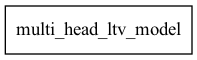

In [7]:
from tensorflow.keras.utils import plot_model

# 确保模型已构建，可以先跑一条样本
sample = next(iter(dataset))
model(sample)  # 让模型初始化权重和结构

plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

In [14]:
import tensorflow as tf

# 1. 启动 profiler
tf.profiler.experimental.start('logs')

# 2. 跑一次模型（比如跑一个 batch）
_ = model(sample)  # 你之前已经拿过 sample = next(iter(dataset))

# 3. 停止 profiler
tf.profiler.experimental.stop()

2025-06-19 19:00:15.199199: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2025-06-19 19:00:15.199238: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2025-06-19 19:00:15.284858: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2025-06-19 19:00:15.298813: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2025-06-19 19:00:15.310071: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/plugins/profile/2025_06_19_19_00_15

2025-06-19 19:00:15.311801: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/plugins/profile/2025_06_19_19_00_15/CK-L220022-2.local.trace.json.gz
2025-06-19 19:00:15.312696: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/plugins/profile/2025_06_19_19_00_15

2025-06-19 19:00:15.312851: I tensorflow/c

In [9]:
model.save("my_model.h5")

NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

In [16]:
for batch in dataset.take(10):
    # 示例 Tensor（比如从 batch 中某列提取出来的稀疏特征）
    tensor = tf.gather(batch['user_sparse_features'], indices=0, axis=1)
    # 判断是否含有 -1
    contains_negative_one = tf.reduce_any(tf.equal(tensor,0))
    # 打印结果（在 Eager 模式下，contains_negative_one 是一个布尔 Tensor）
    print("是否包含 0:", contains_negative_one.numpy())  # True 或 False
    print(tensor)

是否包含 0: False
tf.Tensor(
[ 3.  1.  2.  1.  3.  2.  1.  5.  2.  3.  1.  4.  1.  2.  3.  3.  4.  4.
  4.  3.  3.  2.  3.  3.  1.  2.  2.  4.  5.  3.  1.  4.  3.  2.  3.  2.
  4.  4.  3.  2.  3.  5.  1.  4.  2.  1.  1.  2.  1.  4.  5.  2.  3.  1.
  2.  1.  1.  3.  5.  4.  3.  5.  2.  5.  4.  1.  4.  5.  2.  3.  4.  3.
  3.  3.  4.  3.  2.  5.  4.  2.  4.  4.  5.  4.  1.  1.  2.  4.  4.  2.
  2.  5.  2.  2.  3.  4.  1.  2.  4.  3.  2.  4.  5.  2.  4.  5.  2.  2.
  1.  3.  2.  3.  1.  5.  2.  5.  4.  2.  3.  4.  2.  3.  3.  5.  2.  4.
  2.  3.  5.  5.  2.  1.  5.  3.  4.  2.  3.  3.  5.  1.  1.  4.  4.  3.
  4.  2.  4.  3.  4.  5.  2.  2.  5.  3.  3.  1.  5.  5.  2.  3.  5.  3.
  4.  2.  1.  1.  2.  1.  5.  5.  4.  2.  3.  1.  4.  5.  3.  4.  1.  4.
  4.  3.  2.  5.  2.  3.  2.  1.  3.  5.  5.  4.  5.  1.  5.  4.  5.  2.
  4.  4.  1.  5.  1.  2.  1.  3.  3.  3.  5.  3.  2.  4.  1.  2.  5.  1.
  1.  4.  2.  4.  2.  2.  4.  1.  2.  4.  2.  3.  5.  1.  3.  1.  4.  4.
  1.  4.  1.  2.  2.  4.  